In [13]:
import numpy as np
import matplotlib.pyplot as plt

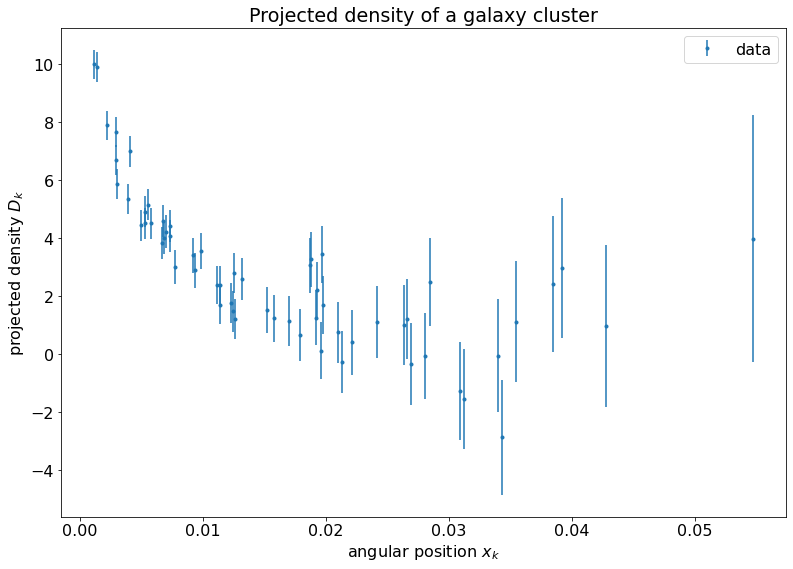

In [14]:
#Marine's Solution until Part 1 and Question 1a) of part 2
x, D, sigma = np.loadtxt('ProjectedDensity.dat', unpack = True)

plt.rcParams['figure.figsize']=[13,9]
plt.rcParams.update({'font.size':16})
plt.errorbar(x, D, yerr=sigma, fmt='.', label='data')
plt.xlabel(r'angular position $x_k$')
plt.ylabel(r'projected density $D_k$')
plt.title('Projected density of a galaxy cluster')
plt.legend()
plt.show()

In [15]:
#1b)
N = 60
M = 10
theta = np.zeros(10)
delta_x = (x[-1] - x[0])/M
for j in range(0, M, 1):
    theta[j] = x[0] + delta_x*(j+1-1./2.)
    
#print(theta)
#post-debugging, the error was identified in the definition of the delta function. Correcting for the same, we get:
def Delta(a,b):
    if(a==b):
        return 1
    else:
        return 0
    
T = np.zeros([N, M])

for k in range(N):
    for j in range(M):
        sum_1 = np.max([0., 1. - abs(x[k] - theta[j])/delta_x])
        sum_2 = (2*Delta(j+1, 1) - Delta(j+1, 2))*np.max([0, 1 - abs(x[k] - theta[j] + delta_x)/delta_x])
        sum_3 = (2*Delta(j+1, M) - Delta(j+1, M-1))*np.max([0, 1 - abs(x[k] - theta[j] - delta_x)/delta_x])
        T_kj = sum_1 + sum_2 + sum_3
        T[k, j] = T_kj
        
#print(T)
a_start = np.array([1., 1, 1., 1., 1., 1., 1., 1., 1., 1.])

def F(a_start):
    F = np.zeros(N)
    for k in range(N):
        summe = 0
        for j in range(M):
            summe += T[k, j]*a_start[j]
        F[k] = summe
    return F

#print(F(a_start))
#print(D_k)

def gradient(F):
    gradient = np.zeros(10)
    for i in range(M):
        summe = 0
        for k in range(N):
            summe += 2.*(F[k]-D[k])*T[k, i]/sigma[k]**2
        gradient[i] = summe
    return gradient
def hessian(F):
    hessian = np.zeros([M,M])
    for i in range(M):
        for j in range(M):
            for k in range(N):
                hessian[i][j] += 2.*(T[k][j]*T[k][i])/(sigma[k]**2)
    return hessian
    
term1 = np.linalg.inv(hessian(F(a_start)))
term2 = gradient(F(a_start))
a_it = a_start
a = np.zeros(M)
for it in range(1):
    for j in range(M):
        summe = 0
        for i in range(M):
            summe += np.linalg.inv(hessian(F))[j,i]*gradient(F(a_start))[i]
        a[j] = a_it[j] - summe
    a_it = a
print(a)

[  8.16639313   2.97358943   1.36464881   1.7225722    0.69038267
  -0.44691496  -0.64182246   5.59366402 -11.75007117  -1.25931381]


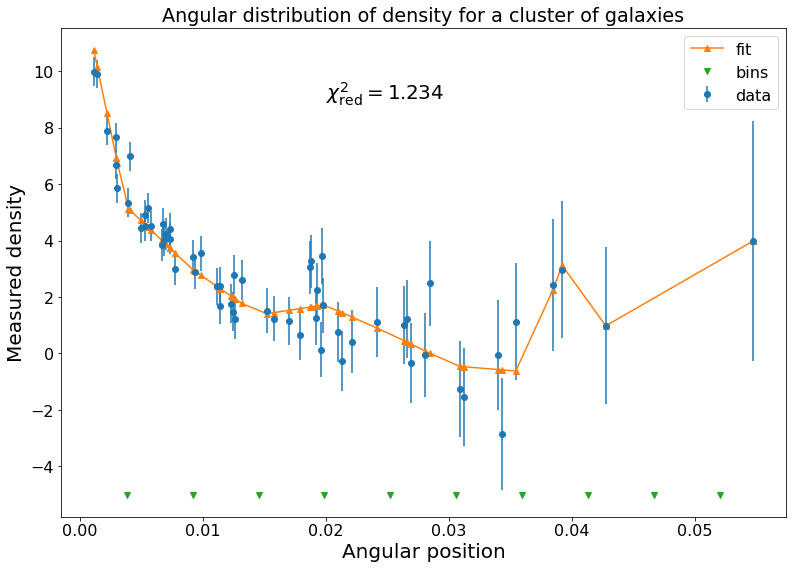

In [16]:
#Using the code from the previous solution notebook
# c) Gaussian likelihood

# Chi-square:
def chi2(F):
	return np.sum((F-D)**2/sigma**2)

# Gradient of chi-square:
def gra_chi2(F):
	gra=np.zeros(M)
	sum2=0.
	for i in range(M):
		for k in range(len(x)):
			sum2 = sum2 + 2*((F[k]-D[k])/sigma[k]**2)*T[k,i]
		gra[i]=sum2
		sum2=0.
	return gra

# Hessian of chi-square:
hess_chi2=np.zeros((M,M))
sum2=0.
for i in range(M):
	for j in range(M):
		for k in range(len(x)):
			sum2 = sum2 + 2*T[k,i]*T[k,j]/sigma[k]**2
		hess_chi2[i,j]=sum2
		sum2=0.

# Find best fit via Newton-Raphson:
a1 = np.linspace(1,M,M)
F1 = np.dot(T,a1)

a = a1 - np.dot(np.linalg.inv(hess_chi2),gra_chi2(F1))
F = np.dot(T,a)

chi2_red = chi2(F)/(len(x)-M-1.)

plt.rcParams['figure.figsize']=[13,9]
plt.rcParams.update({'font.size':16})
plt.errorbar(x, D, yerr=sigma, fmt='o', label='data')
plt.plot(x, F, '^-', label='fit')
plt.plot(theta, -5*theta/theta, 'v', label='bins')
plt.text(0.02,9,r'$\chi^2_\mathrm{red}=$'+str(np.round(chi2_red,3)), fontsize = 20)
plt.xlabel('Angular position', fontsize = 20)
plt.ylabel('Measured density', fontsize = 20)
plt.legend()
plt.title('Angular distribution of density for a cluster of galaxies')
plt.show()

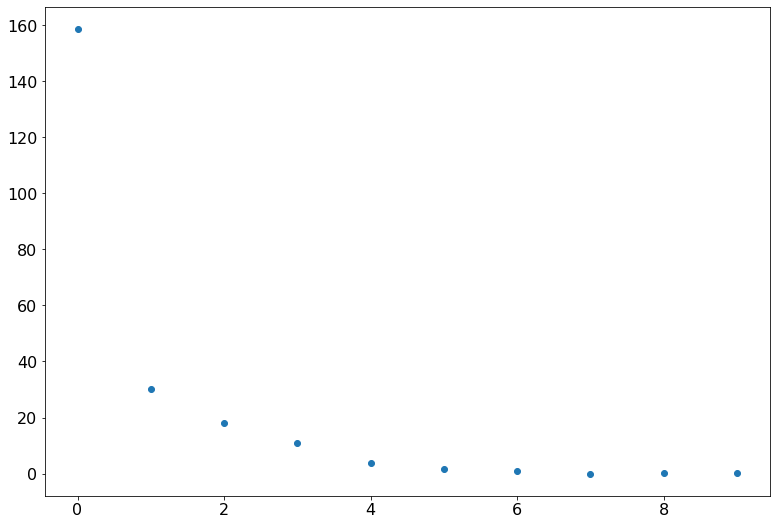

In [17]:
#Q.1a)
lam, eigs = np.linalg.eig(hessian(F))
l = np.arange(0,10,1)
plt.scatter(l,lam)

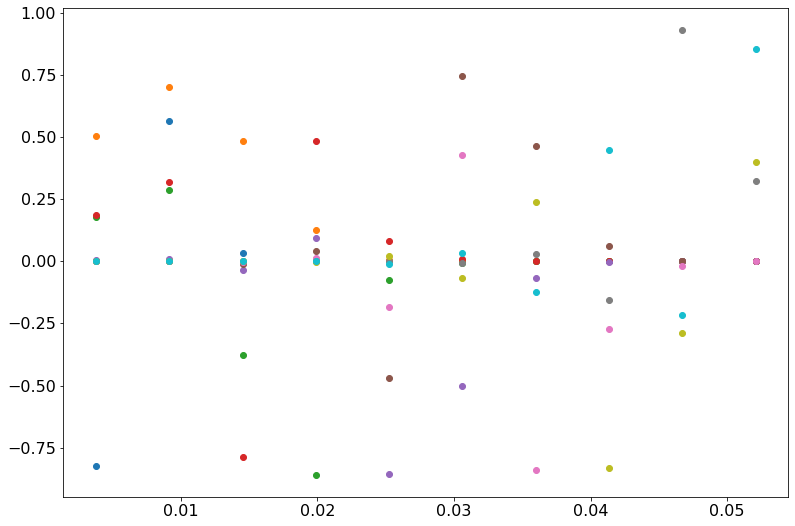

In [18]:
plt.plot(theta,eigs,'o')

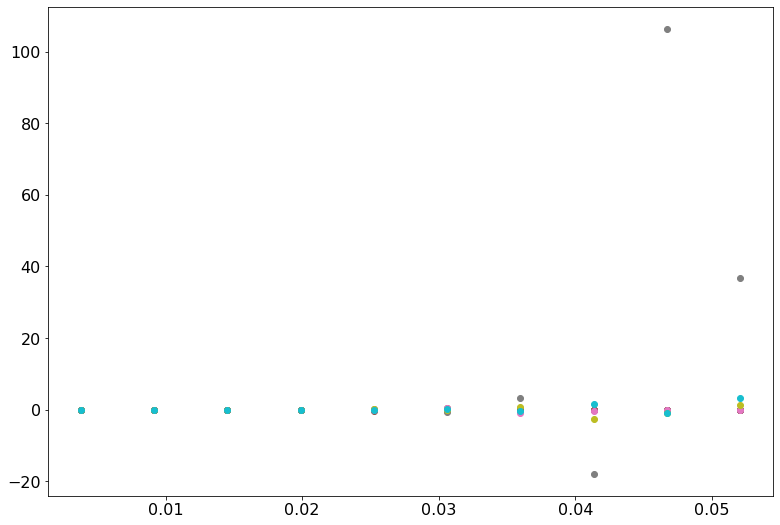

In [19]:
plt.plot(theta,eigs/lam, 'o')

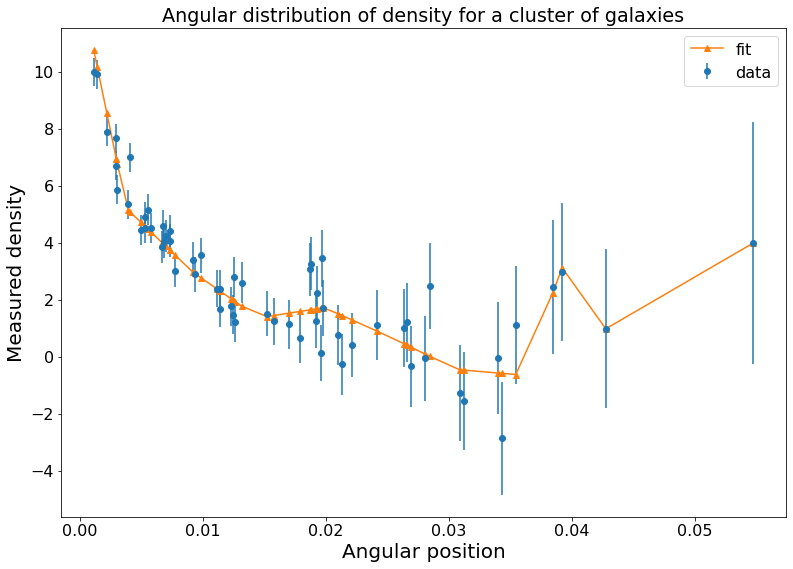

In [20]:
#1.b) #Based on Rintaro's solution (ありがとう)
T_new = np.matmul(T,np.linalg.inv(eigs))
c_l = np.matmul(eigs,a)
hessian_new = np.zeros((M,M))
summe=0.
for i in range(M):
    for j in range(M):
        for k in range(N):
            summe = summe + 2*T_new[k,i]*T_new[k,j]/sigma[k]**2
        hessian_new[i,j]=summe
        summe=0.
def gradient_new(F):
    gradient=np.zeros(M)
    summe=0.
    for i in range(M):
        for k in range(N):
            summe = summe + 2*((F[k]-D[k])/sigma[k]**2)*T_new[k,i]
        gradient[i]=summe
        summe=0.
    return gradient
F1 = np.dot(T_new,c_l)
c = c_l - np.dot(np.linalg.inv(hessian_new),gradient_new(F1))
F = np.dot(T_new,c)
plt.rcParams['figure.figsize']=[13,9]
plt.rcParams.update({'font.size':16})
plt.errorbar(x, D, yerr=sigma, fmt='o', label='data')
plt.plot(x, F, '^-', label='fit')
plt.xlabel('Angular position', fontsize = 20)
plt.ylabel('Measured density', fontsize = 20)
plt.legend()
plt.title('Angular distribution of density for a cluster of galaxies')
plt.show()

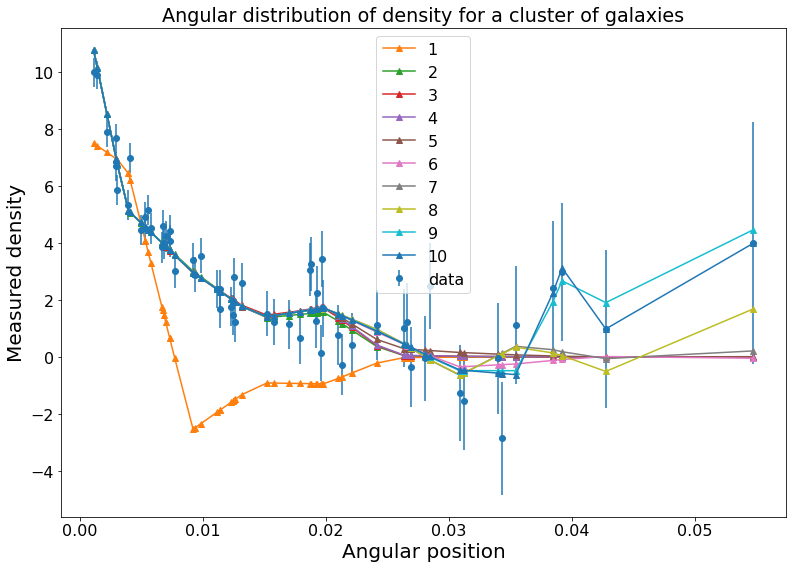

In [21]:
#1.b)-contd.
plt.errorbar(x, D, yerr=sigma, fmt='o', label='data')
plt.xlabel('Angular position', fontsize = 20)
plt.ylabel('Measured density', fontsize = 20)
plt.title('Angular distribution of density for a cluster of galaxies')
chisq_red=list()

for M in (range(1,11)):
    T_new=np.matmul(T,np.linalg.inv(eigs))
    hessian_new=np.zeros((M,M))
    summe=0.
    for i in range(M):
        for j in range(M):
            for k in range(N):
                summe = summe + 2*T_new[k,i]*T_new[k,j]/sigma[k]**2
            hessian_new[i,j]=summe
            summe=0.
    def gradient_new(F):
        gradient=np.zeros(M)
        summe=0.
        for i in range(M):
            for k in range(len(x)):
                summe = summe + 2*((F[k]-D[k])/sigma[k]**2)*T_new[k,i]
            gradient[i]=summe
            summe=0.
        return gradient
    F1 = np.dot(T_new[:,0:M],c_l[0:M])
    c = c_l[0:M] - np.dot(np.linalg.inv(hessian_new),gradient_new(F1))
    F = np.dot(T_new[:,0:M],c)
    chisq_red.append(chi2(F[M])/(N-M-1.))
    plt.plot(x, F, '^-', label=(M))
plt.legend()
plt.show()

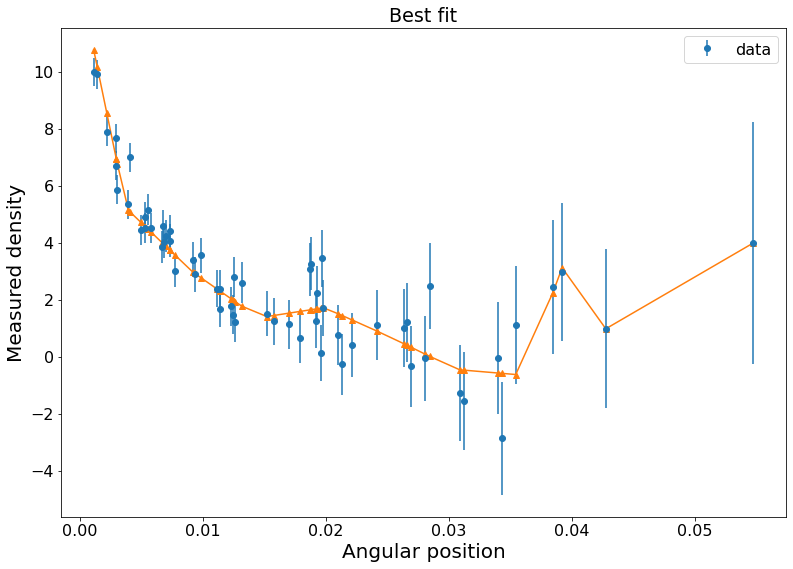

In [22]:
#1.c)
plt.errorbar(x, D, yerr=sigma, fmt='o', label='data')
plt.xlabel('Angular position', fontsize = 20)
plt.ylabel('Measured density', fontsize = 20)
plt.title('Best fit')
T_new=np.matmul(T,np.linalg.inv(eigs))
hessian_new=np.zeros((M,M))
summe=0.
for i in range(M):
    for j in range(M):
        for k in range(N):
            summe = summe + 2*T_new[k,i]*T_new[k,j]/sigma[k]**2
        hessian_new[i,j]=summe
        summe=0.
def gradient_new(F):
    gradient=np.zeros(M)
    summe=0.
    for i in range(M):
        for k in range(N):
            summe = summe + 2*((F[k]-D[k])/sigma[k]**2)*T_new[k,i]
        gradient[i]=summe
        summe=0.
    return gradient
a1 = np.linspace(1,1,num=M)
F1 = np.dot(T_new[:,0:M],a1)
a = a1 - np.dot(np.linalg.inv(hessian_new),gradient_new(F1))
F = np.dot(T_new[:,0:M],a)
chisq_red = chi2(F[M])/(N-M-1.)
plt.plot(x, F, '^-')
plt.legend()
plt.show()

In [24]:
#People who worked on the notebook: Rintaro, Gregor, Marine, Elias, Felix, Bhashin